In [1]:
import nibabel as nb
import SimpleITK as sitk
import matplotlib.pyplot as plt
import numpy as np 

import torch 
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

from torch import nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

from sklearn.model_selection import train_test_split
from datetime import datetime

In [36]:
import torch
import torch.nn as nn
import torchvision
resnet = torchvision.models.resnet.resnet50(pretrained=False)

# https://github.com/kevinlu1211/pytorch-unet-resnet-50-encoder


class ConvBlock(nn.Module):
    """
    Helper module that consists of a Conv -> BN -> ReLU
    """

    def __init__(self, in_channels, out_channels, padding=1, kernel_size=3, stride=1, with_nonlinearity=True):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, padding=padding, kernel_size=kernel_size, stride=stride)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.with_nonlinearity = with_nonlinearity

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        if self.with_nonlinearity:
            x = self.relu(x)
        return x


class Bridge(nn.Module):
    """
    This is the middle layer of the UNet which just consists of some
    """

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.bridge = nn.Sequential(
            ConvBlock(in_channels, out_channels),
            ConvBlock(out_channels, out_channels)
        )

    def forward(self, x):
        return self.bridge(x)


class UpBlockForUNetWithResNet50(nn.Module):
    """
    Up block that encapsulates one up-sampling step which consists of Upsample -> ConvBlock -> ConvBlock
    """

    def __init__(self, in_channels, out_channels, up_conv_in_channels=None, up_conv_out_channels=None,
                 upsampling_method="conv_transpose"):
        super().__init__()

        if up_conv_in_channels == None:
            up_conv_in_channels = in_channels
        if up_conv_out_channels == None:
            up_conv_out_channels = out_channels

        if upsampling_method == "conv_transpose":
            self.upsample = nn.ConvTranspose2d(up_conv_in_channels, up_conv_out_channels, kernel_size=2, stride=2)
       # elif upsampling_method == "bilinear":
        #    self.upsample = nn.Sequential(
         #       nn.Upsample(mode='bilinear', scale_factor=2),
          #      nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1)
            #)
            
        self.conv_block_1 = ConvBlock(in_channels, out_channels)
        self.conv_block_2 = ConvBlock(out_channels, out_channels)

    def forward(self, up_x, down_x):
        """
        :param up_x: this is the output from the previous up block
        :param down_x: this is the output from the down block
        :return: upsampled feature map
        """
        x = self.upsample(up_x)
        x = torch.cat([x, down_x], 1)
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return x


class UNetWithResnet50Encoder(nn.Module):
    DEPTH = 6

    def __init__(self):
        super().__init__()
        resnet = torchvision.models.resnet.resnet50(pretrained=True)
        down_blocks = []
        up_blocks = []
        # se queda con las primeras operaciones: 
        # Sequential(
          #(0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          #(1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          #(2): ReLU(inplace=True)
        # )
        self.input_block = nn.Sequential(*list(resnet.children()))[:3]
        self.input_pool = list(resnet.children())[3]
        for bottleneck in list(resnet.children()):
            if isinstance(bottleneck, nn.Sequential):
                down_blocks.append(bottleneck)
        self.down_blocks = nn.ModuleList(down_blocks)
        self.bridge = Bridge(2048, 2048)
        up_blocks.append(UpBlockForUNetWithResNet50(2048, 1024))
        up_blocks.append(UpBlockForUNetWithResNet50(1024, 512))
        up_blocks.append(UpBlockForUNetWithResNet50(512, 256))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=128 + 64, out_channels=128,
                                                    up_conv_in_channels=256, up_conv_out_channels=128))
        up_blocks.append(UpBlockForUNetWithResNet50(in_channels=64 + 3, out_channels=64,
                                                    up_conv_in_channels=128, up_conv_out_channels=64))

        self.up_blocks = nn.ModuleList(up_blocks)

        self.out = nn.Conv2d(64, 1, kernel_size=1, stride=1)

    def forward(self, x, with_output_feature_map=False):
        pre_pools = dict()
        pre_pools[f"layer_0"] = x
        x = self.input_block(x)
        pre_pools[f"layer_1"] = x
        x = self.input_pool(x)

        # Down blocks
        for i, block_down in enumerate(self.down_blocks, 2):
            x = block_down(x)
            if i == (UNetWithResnet50Encoder.DEPTH - 1):
                continue
            pre_pools[f"layer_{i}"] = x

        x = self.bridge(x)
        
        # Up blocks
        for i, block_up in enumerate(self.up_blocks, 1):
            key = f"layer_{UNetWithResnet50Encoder.DEPTH - 1 - i}"
            x = block_up(x, pre_pools[key])
        output_feature_map = x
        
        # Salida
        x = self.out(x)
        
        del pre_pools
        if with_output_feature_map:
            return x, output_feature_map
        else:
            return x

unet = UNetWithResnet50Encoder()
inp = torch.rand((1, 3, 256, 256))
out = unet(inp)

In [39]:
resnet = torchvision.models.resnet.resnet50(pretrained=False)

resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [31]:
down_blocks

ModuleList(
  (0): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (1): Bottleneck(
      (conv1): Conv2d(256, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [18]:
from torchsummary import summary

if __name__ == '__main__':
    inputs = train_noisyImage[5]
    inputs = np.stack((inputs,)*3, axis=-3)
    inputs = torch.Tensor(inputs)
    out = unet(inputs)

summary(unet,inputs )

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 64, 128, 128]        --
|    └─Conv2d: 2-1                            [-1, 64, 128, 128]        9,408
|    └─BatchNorm2d: 2-2                       [-1, 64, 128, 128]        128
|    └─ReLU: 2-3                              [-1, 64, 128, 128]        --
├─MaxPool2d: 1-2                              [-1, 64, 64, 64]          --
├─ModuleList: 1                               []                        --
|    └─Sequential: 2-4                        [-1, 256, 64, 64]         --
|    |    └─Bottleneck: 3-1                   [-1, 256, 64, 64]         75,008
|    |    └─Bottleneck: 3-2                   [-1, 256, 64, 64]         70,400
|    |    └─Bottleneck: 3-3                   [-1, 256, 64, 64]         70,400
|    └─Sequential: 2-5                        [-1, 512, 32, 32]         --
|    |    └─Bottleneck: 3-4                   [-1, 512, 32, 32]         379,392

Layer (type:depth-idx)                        Output Shape              Param #
├─Sequential: 1-1                             [-1, 64, 128, 128]        --
|    └─Conv2d: 2-1                            [-1, 64, 128, 128]        9,408
|    └─BatchNorm2d: 2-2                       [-1, 64, 128, 128]        128
|    └─ReLU: 2-3                              [-1, 64, 128, 128]        --
├─MaxPool2d: 1-2                              [-1, 64, 64, 64]          --
├─ModuleList: 1                               []                        --
|    └─Sequential: 2-4                        [-1, 256, 64, 64]         --
|    |    └─Bottleneck: 3-1                   [-1, 256, 64, 64]         75,008
|    |    └─Bottleneck: 3-2                   [-1, 256, 64, 64]         70,400
|    |    └─Bottleneck: 3-3                   [-1, 256, 64, 64]         70,400
|    └─Sequential: 2-5                        [-1, 512, 32, 32]         --
|    |    └─Bottleneck: 3-4                   [-1, 512, 32, 32]         379,392

In [3]:
# Error cuadratico medio entre 2 imgs
def MSE(img1, img2):
        cuadradoDeDif = ((img1 -img2) ** 2)
        suma = np.sum(cuadradoDeDif)
        cantPix = img1.shape[0] * img1.shape[1] 
        error = suma / cantPix
        return error

In [4]:
# Importo base de datos

noisyDataSet1_nii = sitk.ReadImage('./noisyDataSet1.nii')
img_noisyDataSet1 = sitk.GetArrayFromImage(noisyDataSet1_nii)

noisyDataSet2_nii = sitk.ReadImage('./noisyDataSet2.nii')
img_noisyDataSet2 = sitk.GetArrayFromImage(noisyDataSet2_nii)

groundTruth_nii = sitk.ReadImage('./groundTruth.nii')
img_groundTruth = sitk.GetArrayFromImage(groundTruth_nii)

print("noisyDataSet1 shape:",img_noisyDataSet1.shape)
print("noisyDataSet2 shape:",img_noisyDataSet2.shape)
print("groundTruth shape:",img_groundTruth.shape)

noisyDataSet1 shape: (1726, 344, 344)
noisyDataSet2 shape: (1726, 344, 344)
groundTruth shape: (1726, 344, 344)


In [5]:
# Reshape for training

img_noisyDataSet1 =img_noisyDataSet1[:,44:300,44:300]
img_noisyDataSet2 =img_noisyDataSet2[:,44:300,44:300]
img_groundTruth =img_groundTruth[:,44:300,44:300]

img_noisyDataSet1 = np.stack((img_noisyDataSet1,)*3, axis=-3)
img_noisyDataSet2 = np.stack((img_noisyDataSet2,)*3, axis=-3)
img_groundTruth = np.stack((img_groundTruth,)*3 ,axis=-3)

print(img_noisyDataSet1.shape)
print(img_noisyDataSet2.shape)
print(img_groundTruth.shape)

(1726, 3, 256, 256)
(1726, 3, 256, 256)
(1726, 3, 256, 256)


In [6]:
# Acoto conjuntos (OPCIONAL)

img_noisyDataSet1 =img_noisyDataSet1[30:50,:,:,:]
img_noisyDataSet2 =img_noisyDataSet2[30:50,:,:,:]
img_groundTruth =img_groundTruth[30:50,:,:,:]

In [7]:
# Entrenamiento #

# Loss and optimizer

criterion = nn.MSELoss()
optimizer = optim.Adam(unet.parameters(), lr=0.0001)

# Conjunto de entrenamiento, testeo y validacion

train_noisyImage,test_noisyImage,train_groundTruth,test_groundTruth = train_test_split(img_noisyDataSet1, img_groundTruth, test_size=0.2)

valid_noisyImage = train_noisyImage[-5:,:,:,:]
valid_groundTruth = train_groundTruth[-5:,:,:,:]

train_noisyImage = train_noisyImage [:-5,:,:,:]
train_groundTruth = train_groundTruth[:-5:,:,:,:]

In [8]:
# Prueba con un slice 
if __name__ == '__main__':
    inputs = train_noisyImage[5]
    inputs = np.stack((inputs,)*3, axis=-3)
    inputs = torch.Tensor(inputs)
    out = unet(inputs)
    
gT = train_groundTruth[5]
gT = np.stack((gT,)*3, axis=-3)
gT = torch.Tensor(gT)

inputs_np = inputs.detach().numpy()
out_np = out.detach().numpy()
gT_np = gT.detach().numpy()

MSE_orig = MSE(inputs_np[0,0,:,:],gT_np[0,0,:,:])
MSE_test = MSE(out_np[0,0,:,:],gT_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)


# Guardar imgs en formato .nii

img_inputs = sitk.GetImageFromArray(inputs_np[0,0,:,:])
sitk.WriteImage(img_inputs,'inputsNoTrain.nii')

img_out = sitk.GetImageFromArray(out_np[0,0,:,:])
sitk.WriteImage(img_out,'outNoTrain.nii')


img_gT = sitk.GetImageFromArray(gT_np[0,0,:,:])
sitk.WriteImage(img_gT,'groundTruthNoTrain.nii')

MSE orig 0.3047114908695221
MSE test 2.5759923458099365


In [9]:
# Codigo de pag Pytorch
def train_one_epoch(epoch_index, tb_writer):
    running_loss = 0.
    last_loss = 0.
    
    for i in range(0, train_noisyImage.shape[0]):
        
        # Acondicionamiento de datos
        
        inputs = train_noisyImage[i]
        inputs = np.stack((inputs,)*3, axis=-3)
        inputs = torch.Tensor(inputs)
        
        trainGroundTruth = train_groundTruth[i]
        trainGroundTruth = np.stack((trainGroundTruth,)*3, axis=-3)
        trainGroundTruth = torch.Tensor(trainGroundTruth)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = unet(inputs)
        loss = criterion(outputs, trainGroundTruth)

        loss.backward()

        # Adjust learning weights
        optimizer.step()

        # Gather data and report
        running_loss += loss.item()
        
        if i % 10 == 9:
            last_loss = running_loss / 10 # loss en las ultimas 10 imagenes
            print('  image {} loss: {}'.format(i + 1, last_loss))
            tb_x = epoch_index * ((train_noisyImage.shape[0])/10) + i + 1
            tb_writer.add_scalar('Loss/train', last_loss, tb_x)
            running_loss = 0.

    return last_loss

In [10]:
# Initializing in a separate cell so we can easily add more epochs to the same run

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
writer = SummaryWriter('runs/fashion_trainer_{}'.format(timestamp))
epoch_number = 0

EPOCHS = 10

best_vloss = 1_000_000.

for epoch in range(EPOCHS):
    print('EPOCH {}:'.format(epoch_number + 1))

    # Make sure gradient tracking is on, and do a pass over the data
    unet.train(True)
    avg_loss = train_one_epoch(epoch_number, writer)

    # We don't need gradients on to do reporting
    unet.train(False)

    running_vloss = 0.0
    for i in range(0, valid_noisyImage.shape[0]):
        
        vinputs = valid_noisyImage[i]
        vinputs = np.stack((vinputs,)*3, axis=-3)
        vinputs = torch.Tensor(vinputs)
        
        validGroundTruth = valid_groundTruth[i]
        validGroundTruth = np.stack((validGroundTruth,)*3, axis=-3)
        validGroundTruth = torch.Tensor(validGroundTruth)
        
        voutputs = unet(vinputs)
        vloss =  criterion(voutputs, validGroundTruth)
        running_vloss += vloss

    avg_vloss = running_vloss / (i + 1)
    print('LOSS train {} valid {}'.format(avg_loss, avg_vloss))

    # Log the running loss averaged per batch
    # for both training and validation
    writer.add_scalars('Training vs. Validation Loss',
                    { 'Training' : avg_loss, 'Validation' : avg_vloss },
                    epoch_number + 1)
    writer.flush()

    # Track best performance, and save the model's state
    if avg_vloss < best_vloss:
        best_vloss = avg_vloss
        unet_path = 'model_{}_{}'.format(timestamp, epoch_number)
        torch.save(unet.state_dict(), unet_path)

    epoch_number += 1

EPOCH 1:


c:\users\encargado\appdata\local\programs\python\python37\lib\site-packages\torch\nn\modules\loss.py:529: UserWarning: Using a target size (torch.Size([3, 3, 256, 256])) that is different to the input size (torch.Size([3, 1, 256, 256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


  image 10 loss: 1.539904350042343
LOSS train 1.539904350042343 valid 1.601879358291626
EPOCH 2:
  image 10 loss: 0.5908087313175201
LOSS train 0.5908087313175201 valid 0.8530294299125671
EPOCH 3:
  image 10 loss: 0.4466137647628784
LOSS train 0.4466137647628784 valid 0.49844297766685486
EPOCH 4:
  image 10 loss: 0.365770959854126
LOSS train 0.365770959854126 valid 0.335786908864975
EPOCH 5:
  image 10 loss: 0.3164520591497421
LOSS train 0.3164520591497421 valid 0.2864817976951599
EPOCH 6:
  image 10 loss: 0.28150277584791183
LOSS train 0.28150277584791183 valid 0.26229095458984375
EPOCH 7:
  image 10 loss: 0.25398402363061906
LOSS train 0.25398402363061906 valid 0.24508507549762726
EPOCH 8:
  image 10 loss: 0.2305746465921402
LOSS train 0.2305746465921402 valid 0.2280736267566681
EPOCH 9:
  image 10 loss: 0.2102489337325096
LOSS train 0.2102489337325096 valid 0.21249306201934814
EPOCH 10:
  image 10 loss: 0.19260827749967574
LOSS train 0.19260827749967574 valid 0.2018614113330841


In [11]:
# CONJUNTO DE ENTRENAMIENTO

if __name__ == '__main__':
    inputsTrain = train_noisyImage[5]
    inputsTrain = np.stack((inputsTrain,)*3, axis=-3)
    inputsTrain = torch.Tensor(inputsTrain)
    outTrain = unet(inputsTrain)
    
gTtrain = train_groundTruth[5]
gTtrain = np.expand_dims((gTtrain,)*3, axis=-3)
gTtrain = torch.Tensor(gTtrain)


inputsTrain_np = inputsTrain.detach().numpy()
outTrain_np = outTrain.detach().numpy()
gTtrain_np = gTtrain.detach().numpy()

# MSE antes y dsp

MSE_orig = MSE(inputsTrain_np[0,0,:,:],gTtrain_np[0,0,:,:])
MSE_test = MSE(outTrain_np[0,0,:,:],gTtrain_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)

MSE orig 0.3047114908695221
MSE test 0.17877574265003204


In [12]:
scaleForVisualization = 1.2*gT_np.max()

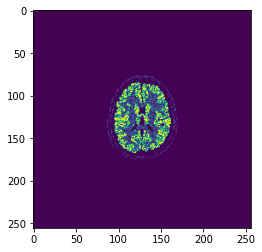

In [13]:
plt.imshow(inputsTrain_np[0,0,:,:] , vmin = 0, vmax = scaleForVisualization)

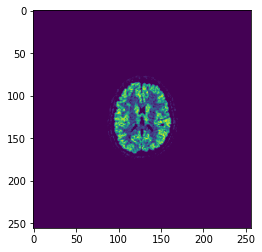

In [14]:
plt.imshow(outTrain_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )

In [15]:
# CONJUNTO DE TESTEO

if __name__ == '__main__':
    inputsTest = test_noisyImage[1]
    inputsTest = np.stack((inputsTest,)*3, axis=-3)
    inputsTest = torch.Tensor(inputsTest)
    outTest = unet(inputsTest)
    
gTtest = test_groundTruth[1]
gTtest = np.expand_dims((gTtest,)*3, axis=-3)
gTtest = torch.Tensor(gTtest)

inputsTest_np = inputsTest.detach().numpy()
outTest_np = outTest.detach().numpy()
gTtest_np = gTtest.detach().numpy()

# MSE antes y dsp

MSE_orig = MSE(inputsTest_np[0,0,:,:],gTtest_np[0,0,:,:])
MSE_test = MSE(outTest_np[0,0,:,:],gTtest_np[0,0,:,:])

print('MSE orig', MSE_orig)
print('MSE test', MSE_test)

MSE orig 0.37879228591918945
MSE test 0.2153274118900299


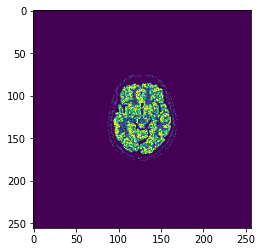

In [16]:
plt.imshow(inputsTest_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )

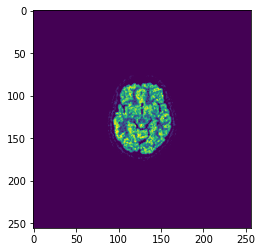

In [17]:
plt.imshow(outTest_np[0,0,:,:] ,vmin = 0, vmax = scaleForVisualization )